In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%load_ext autoreload
%autoreload 2

In [29]:
from implementations import *
from crossvalidation import *
from proj1_helpers import *
from preprocessing import *
from CV_modularised import *
from plots import *

## Load the training data into feature matrix, class labels, and event ids:

In [3]:
DATA_TRAIN_PATH = 'data/train.csv'
DATA_TEST_PATH = 'data/test.csv'
y, tX, ids = load_csv_data(DATA_TRAIN_PATH, sub_sample=True)
y_test, tX_test, ids_test = load_csv_data(DATA_TEST_PATH, sub_sample=True)
features_name = np.genfromtxt('data/train.csv', delimiter=",", dtype=str,max_rows=1)[2:]

# Data exploration

Let's start exploring our dataset by printing some of its characteristics:

In [4]:
print("Our training input array tX is of shape:",tX.shape)
print("Our testing input array tX is of shape:",tX_test.shape)
print("Our training response array y is of shape:",len(y))
print("Our training index array ids is of shape:",len(ids))
print("Our training features' names aray features_name is of shape:",len(features_name), ' \n')
print("Printing the first rows of tX:", tX[0:1,:], '\n')
print("Printing the binary values that can take y:", np.unique(y),'\n')
print("Printing the features' names:", features_name)

Our training input array tX is of shape: (5000, 30)
Our testing input array tX is of shape: (11365, 30)
Our training response array y is of shape: 5000
Our training index array ids is of shape: 5000
Our training features' names aray features_name is of shape: 30  

Printing the first rows of tX: [[ 1.38470e+02  5.16550e+01  9.78270e+01  2.79800e+01  9.10000e-01
   1.24711e+02  2.66600e+00  3.06400e+00  4.19280e+01  1.97760e+02
   1.58200e+00  1.39600e+00  2.00000e-01  3.26380e+01  1.01700e+00
   3.81000e-01  5.16260e+01  2.27300e+00 -2.41400e+00  1.68240e+01
  -2.77000e-01  2.58733e+02  2.00000e+00  6.74350e+01  2.15000e+00
   4.44000e-01  4.60620e+01  1.24000e+00 -2.47500e+00  1.13497e+02]] 

Printing the binary values that can take y: [0. 1.] 

Printing the features' names: ['DER_mass_MMC' 'DER_mass_transverse_met_lep' 'DER_mass_vis' 'DER_pt_h'
 'DER_deltaeta_jet_jet' 'DER_mass_jet_jet' 'DER_prodeta_jet_jet'
 'DER_deltar_tau_lep' 'DER_pt_tot' 'DER_sum_pt' 'DER_pt_ratio_lep_tau'
 'DER

In [5]:
print("The number of Higgs signal particules is", len(y[y==1]), '-',round(len(y[y==1])*100/len(y),0),'%')
print("The number of background particules is", len(y[y==0]), '-',round(len(y[y==0])*100/len(y),0),'%')

The number of Higgs signal particules is 1643 - 33.0 %
The number of background particules is 3357 - 67.0 %


#### Boxplot analysis

We can plot boxplots for each features to analyse feature distributions and check for outliers presence. 

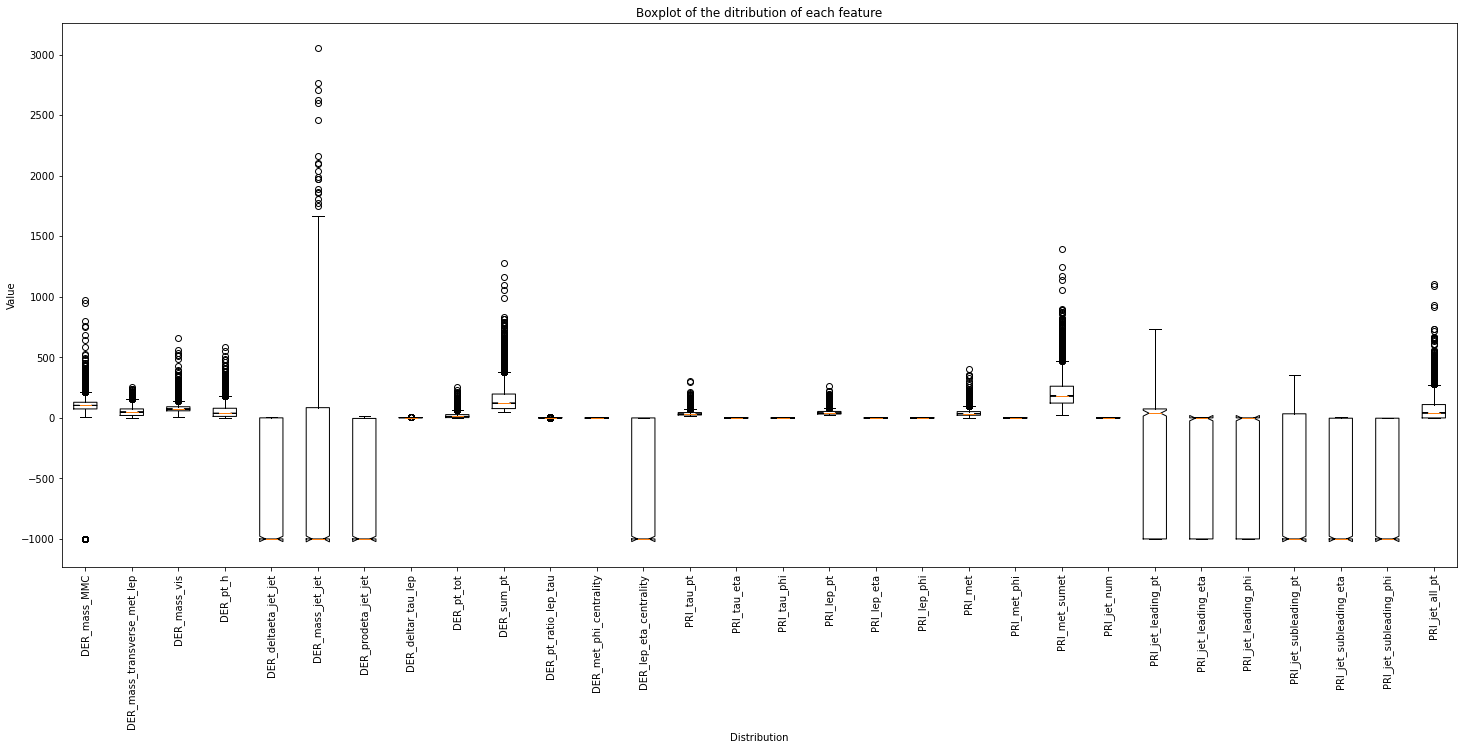

In [6]:
figure = plt.figure(figsize=(25,10))
plt.boxplot(tX, notch=True, labels = features_name, manage_ticks=True)
plt.xticks(rotation=90)
plt.xlabel('Distribution')
plt.ylabel('Value')
plt.title('Boxplot of the ditribution of each feature')
plt.show()

It is clear that some of features contain outliers, hence we will need to remove them in the processing part. 

#### Features classes

As we know there are only one feature that is an integer and categorical, we can take advantage of it to classify our features and see their prediction power.

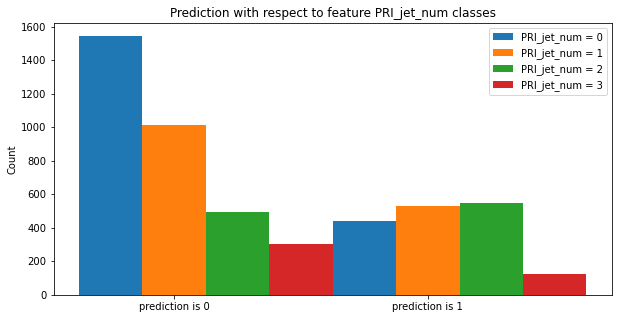

In [7]:
fig = plt.figure(figsize=(10,5))
feature_classes = {
    0: tX[:,22] == 0,
    1: tX[:,22] == 1,
    2: tX[:,22] == 2,
    3: tX[:,22] == 3,
}

labels = ['PRI_jet_num = 0', 'PRI_jet_num = 1', 'PRI_jet_num = 2', 'PRI_jet_num = 3']
w = 0.25

for i in range(len(feature_classes)):
    y_class = y[feature_classes[i]]
    plt.bar(i*w+np.array([0,1]),[len(y_class[y_class==0]),len(y_class[y_class==1])], width=w)

plt.xticks(np.array([0,1]) + w, labels = ('prediction is 0', 'prediction is 1') )
plt.ylabel('Count')
plt.title('Prediction with respect to feature PRI_jet_num classes')
plt.legend(labels)
plt.show()

It seems that class 0 features have a prevalence on the background particule prediction, and the classes 0,1,2 have an impact on the signal particule prediction.

#### Features' distributions analysis

Let's analyse the distribution of each feature with respect to the label. These distributions will help us deduce which features are more important for classification and which are less important.

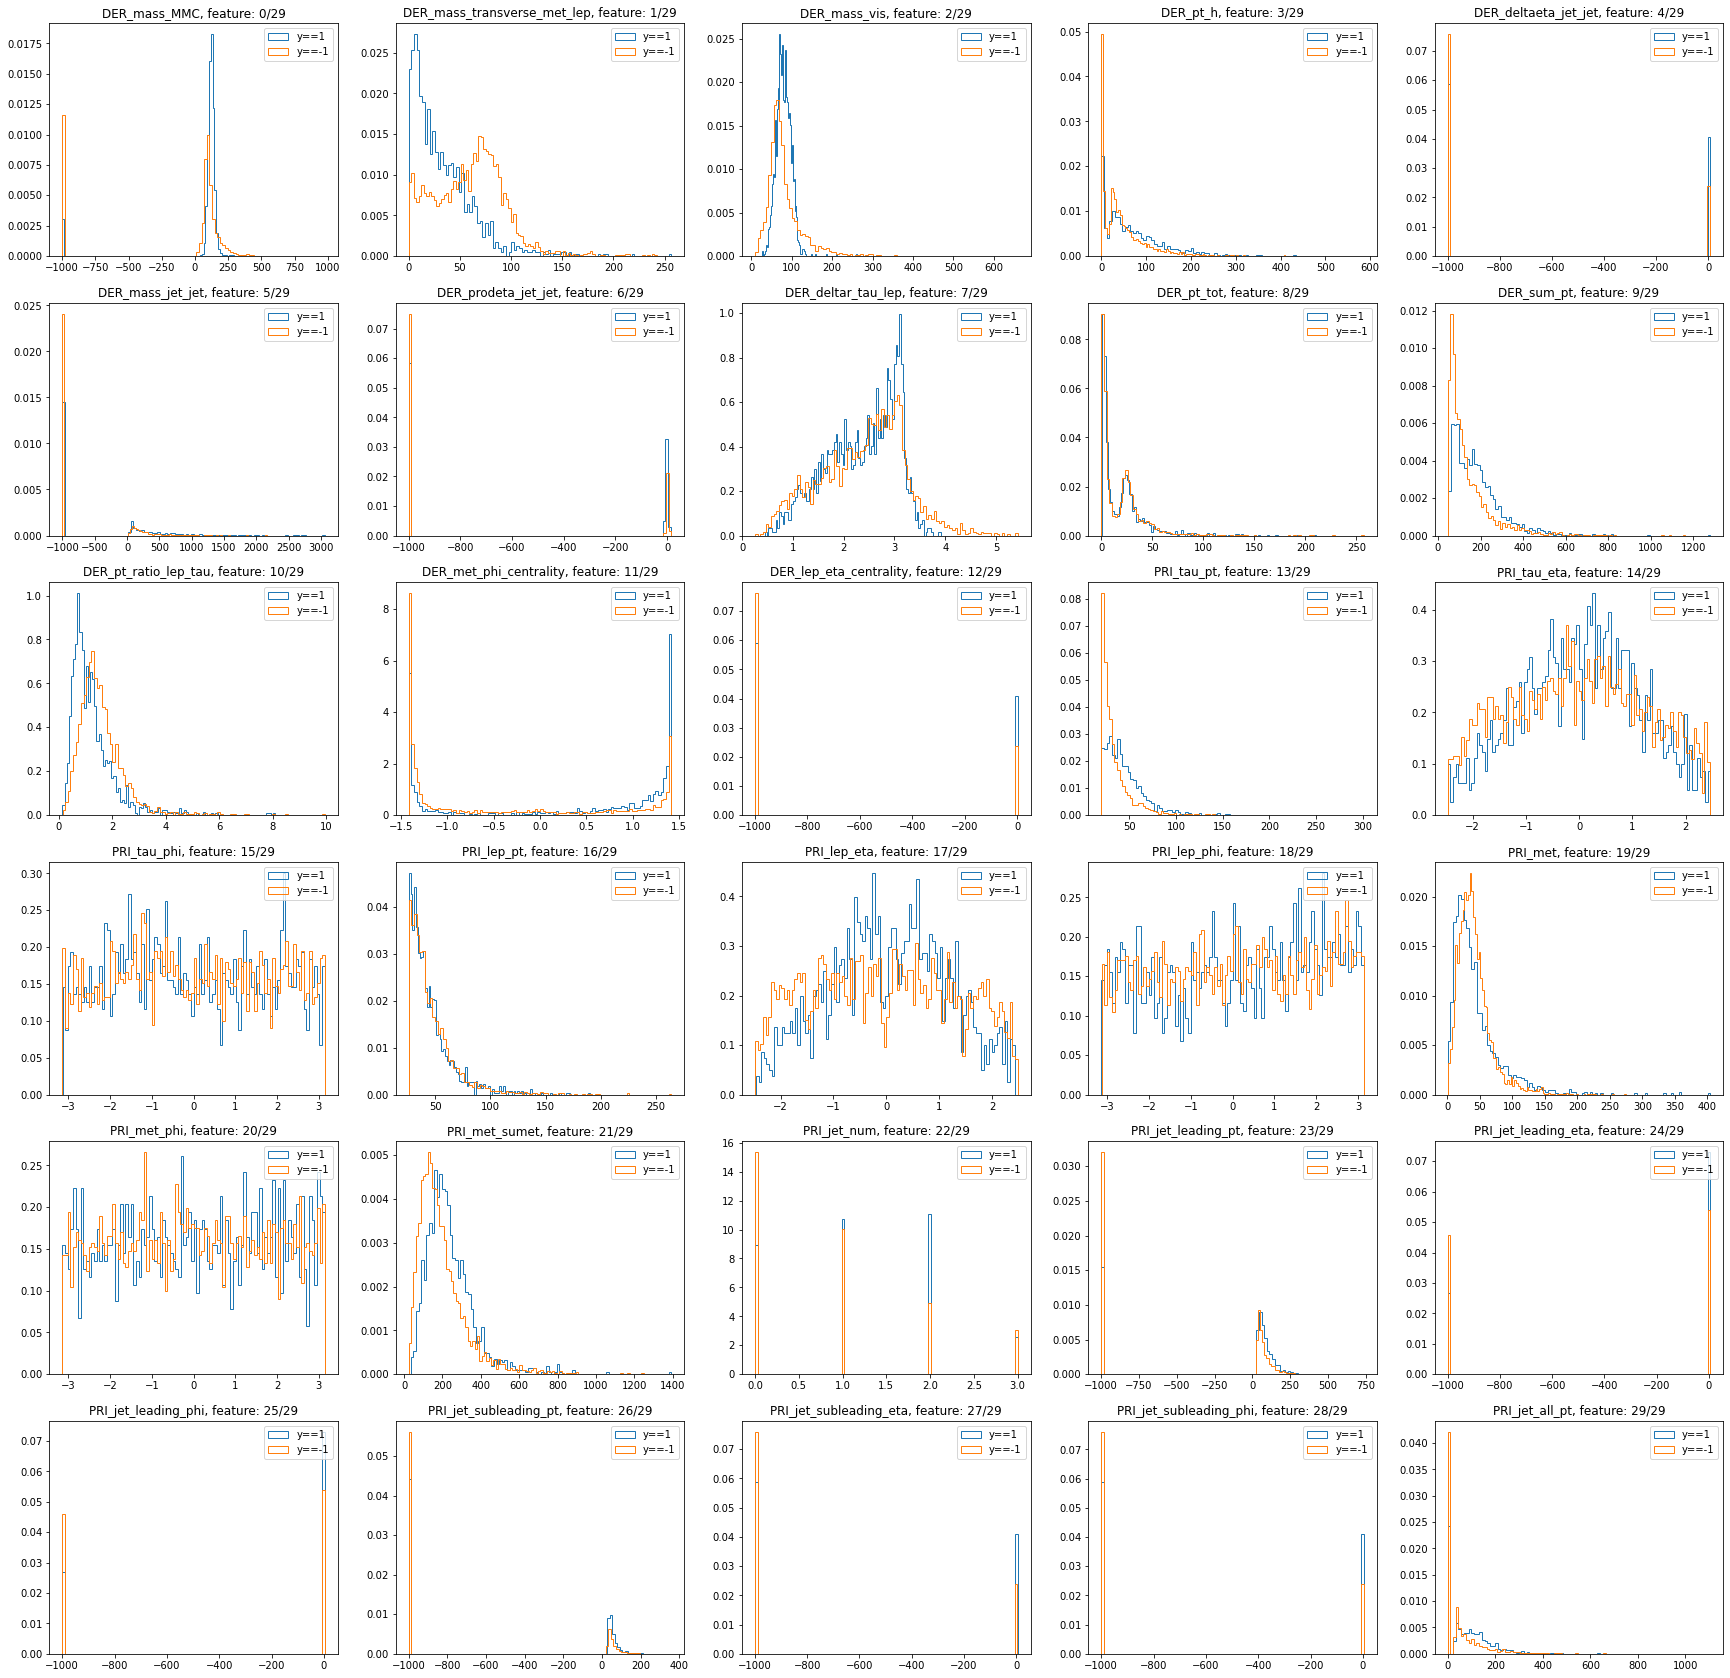

In [8]:
fig = plt.figure(figsize=(30,30))

for i in range(tX.shape[1]):
    ax = plt.subplot(6, 5, i+1)
    ax.hist(tX[[y==1][0], i], bins=100, histtype='step', label="y==1", density=True)
    ax.hist(tX[[y==0][0], i], bins=100, histtype='step', label="y==-1", density=True)
    plt.legend()
    plt.title("{name}, feature: {id}/{tot}".format(name=features_name[i],id=i,tot=len(features_name)-1), fontsize=12)
    
plt.show()

## Feature processing

In [9]:
# remove useless features
print('Useless features process :')
tX_, tX_test_= remove_useless_features(tX, tX_test)
print(' ')

# we manage the missing values
print('Missing values process :')
tX_, tX_test_ = missing_values(tX_, tX_test_)
print('New shape of the training set and test set : ')
print(tX_.shape)
print(tX_test_.shape)

# delete outliers :
print('Outliers process :')
print('On training set :')
tX_, y_ = outliers(tX_, y)
print(' ')

# remove features with 0 standard deviation :
print('Features with 0 standard deviation process :')
tX_, tX_test_= remove_std_0(tX_, tX_test_)
print(' ')

# feature engineering

# standardize :
tX_, mean, std = standardize(tX_)
tX_test_, mean_, std_ = standardize(tX_test_, mean, std)

# we add a column of 1 to our X matrices :
tX_ = offset(tX_)
tX_test_ = offset(tX_test_)

print('Shape of the preprocessed training set : ', tX_.shape)
print(' ')
print('Head of the preprocessed training set')
print(tX_[:5,])

#...

Useless features process :
4  useless features have been removed
 
Missing values process :
0  features have been removed
New shape of the training set and test set : 
(5000, 26)
(11365, 26)
Outliers process :
On training set :
With outliers :  (5000, 26)
Without outliers :  (4847, 26)
 
Features with 0 standard deviation process :
0  features with a standard deviation equal to 0 have been removed
 
Shape of the preprocessed training set :  (4847, 27)
 
Head of the preprocessed training set
[[ 1.          0.46648862  0.03840795  0.52385297 -0.45745139 -1.45355162
  -0.76365794  1.75205621  0.8847893   1.22995509  0.49801948  0.18714611
   1.32793029 -1.4208047  -0.24580224  0.84309402  1.80377939 -0.84778554
   0.51851385  1.10009611 -0.15651552  1.56274665  0.32768887 -0.21482371
   1.23152595 -2.41401347  0.56845174]
 [ 1.          2.29658386  0.63741965  1.29975061 -0.85980106 -0.07123331
  -0.16435273  0.05436468  1.80625571  1.48763724 -0.26405119  0.63789554
  -1.01619942  0.0580

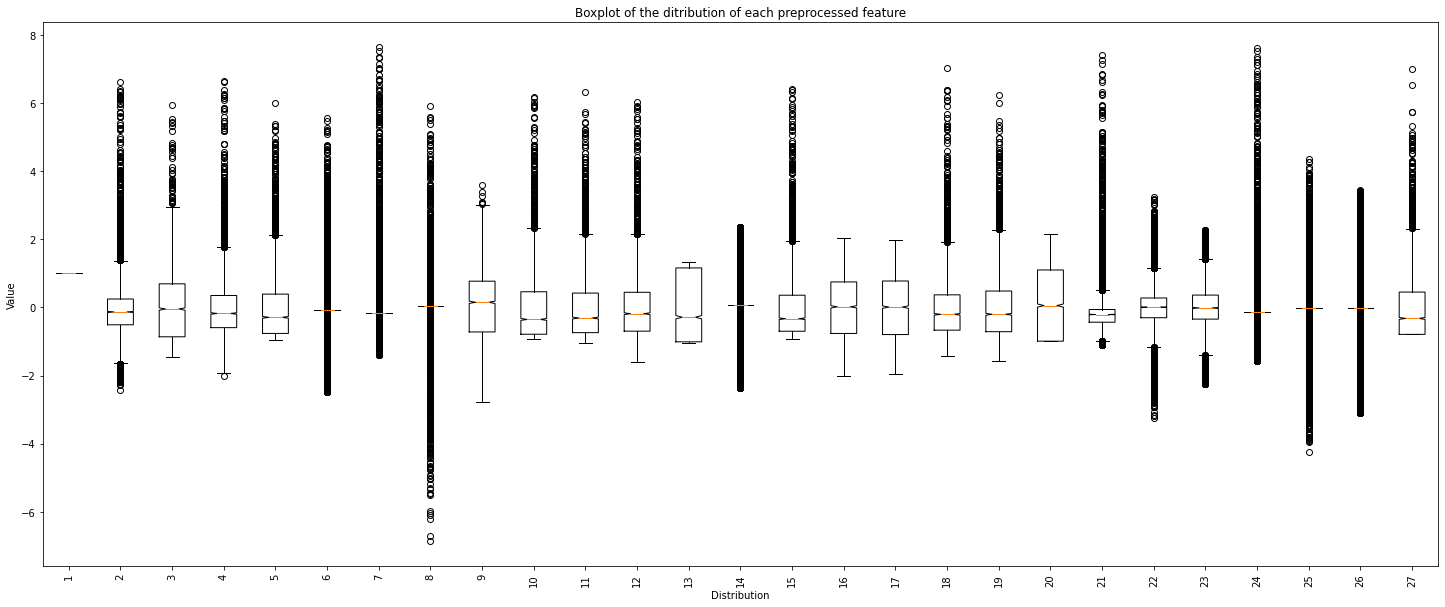

In [10]:
figure = plt.figure(figsize=(25,10))
plt.boxplot(tX_, notch=True, manage_ticks=True)
plt.xticks(rotation=90)
plt.xlabel('Distribution')
plt.ylabel('Value')
plt.title('Boxplot of the ditribution of each preprocessed feature')
plt.show()

## Applying methods

In [37]:
seed = np.random.seed(10)

### Method 1 : least_squares_GD

#### "Parameters pre-tunage"

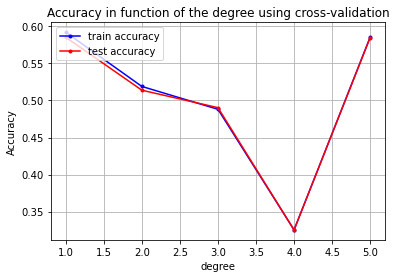

Accuracies for different degree :
[0.5852601156069364, 0.513831544178365, 0.4902972749793559, 0.32535094962840627, 0.5848472336911643]


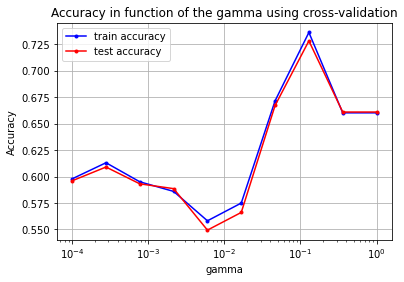

Accuracies for different gamma :
[0.5959950454170108, 0.6090008257638315, 0.5931048720066061, 0.5885631709331132, 0.5493393889347646, 0.5660611065235343, 0.667217175887696, 0.7283236994219653, 0.6610239471511148, 0.6610239471511148]


In [43]:
#Fixed parameters :
k_fold=4
max_iters = 50

#Parameters to tune :
degrees = 1+np.arange(5)
gamma=1e-3

best_degree, acc_te_deg, acc_tr_deg = tune_best_one(y_, tX_, k_fold, least_squares_GD, seed=seed, params=degrees, gamma=gamma, max_iters=max_iters, name='degree')

CV_param_plot(degrees, acc_tr_deg, acc_te_deg, name_param="degree")

print("Accuracies for different degree :")
print(acc_te_deg)

#Parameters to tune :
degree = best_degree
gammas=np.logspace(-4, 0, 10)

best_gam, acc_te_gam, acc_tr_gam = tune_best_one(y_, tX_, k_fold, least_squares_GD, seed=seed, params=gammas, degree=degree, max_iters=max_iters, name='gamma')

CV_param_plot(gammas, acc_tr_gam, acc_te_gam, name_param="gamma")

print("Accuracies for different gamma :")
print(acc_te_gam)

Using this "pre-tunage", we can apply tune simultanesouly degree and gamma on a smaller grid search (to avoid very long computation).

In [48]:
degrees = [1, 2, 3]
gammas = np.linspace(1e-2, 5e-1, 9)

#### Parameters tunage

In [49]:
# cross validation
deg_ls_gd, gamma_ls_gd, acc_te_ls_gd, acc_tr_ls_gd = tune_best_deg_gam(y_, tX_, k_fold, least_squares_GD, degrees=degrees, gammas=gammas, seed=seed, max_iters=max_iters)
print('The degree obtaining the maximum test accuracy is : ', deg_ls_gd)
print(' ')
print('Combined with a best learning rate gamma : ', gamma_ls_gd)
print(' ')
print('And the associated maximum test accuracy is : ', acc_te_ls_gd)
print(' ')
print('While the train accuracy is : ', acc_tr_ls_gd)

The degree obtaining the maximum test accuracy is :  3
 
Combined with a best learning rate gamma :  0.01
 
And the associated maximum test accuracy is :  0.5875309661436829
 
While the train accuracy is :  0.5876685934489403


### Method 2 : least_squares_SGD

#### "Parameters pre-tunage"

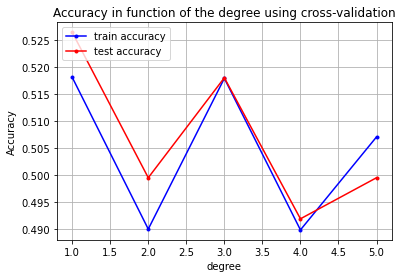

Accuracies for different degree :
[0.5265221878224975, 0.49948400412796695, 0.5180598555211559, 0.49184726522187816, 0.49948400412796695]


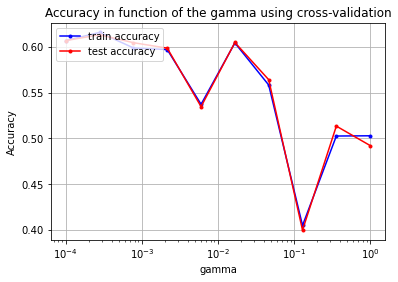

Accuracies for different gamma :
[0.6068111455108359, 0.6132094943240454, 0.6045407636738906, 0.5985552115583075, 0.5345717234262126, 0.6047471620227037, 0.5640866873065017, 0.3995872033023736, 0.5133126934984521, 0.4920536635706914]


In [52]:
#Fixed parameters :
k_fold=5
max_iters = 50
batch_size = 1

#Parameters to tune :
degrees = 1+np.arange(5)
gamma=0.01

best_degree, acc_te_deg, acc_tr_deg = tune_best_one(y_, tX_, k_fold, least_squares_SGD, seed=seed, params=degrees, gamma=gamma, batch_size=batch_size, max_iters=max_iters, name='degree')

CV_param_plot(degrees, acc_tr_deg, acc_te_deg, name_param="degree")

print("Accuracies for different degree :")
print(acc_te_deg)

#Parameters to tune :
degree = best_degree
gammas=np.logspace(-4, 0, 10)

best_gam, acc_te_gam, acc_tr_gam = tune_best_one(y_, tX_, k_fold, least_squares_SGD, seed=seed, params=gammas, degree=degree, max_iters=max_iters, batch_size=batch_size, name='gamma')

CV_param_plot(gammas, acc_tr_gam, acc_te_gam, name_param="gamma")

print("Accuracies for different gamma :")
print(acc_te_gam)

Using this "pre-tunage", we can apply tune simultanesouly degree and gamma on a smaller grid search (to avoid very long computation).

In [56]:
degrees = [1, 2, 3]
gammas = np.linspace(1e-5, 1e-3, 5)

#### Parameters tunage

In [57]:
# cross validation
deg_ls_sgd, gamma_ls_sgd, acc_te_ls_sgd, acc_tr_ls_sgd = tune_best_deg_gam(y_, tX_, k_fold, least_squares_SGD, degrees=degrees, gammas=gammas, seed=seed, batch_size=batch_size, max_iters=max_iters)
print('The degree obtaining the maximum test accuracy is : ', deg_ls_sgd)
print(' ')
print('Combined with a best learning rate gamma : ', gamma_ls_sgd)
print(' ')
print('And the associated maximum test accuracy is : ', acc_te_ls_sgd)
print(' ')
print('While the train accuracy is : ', acc_tr_ls_sgd)

[0.0007525, 1e-05, 0.000505]
The degree obtaining the maximum test accuracy is :  1
 
Combined with a best learning rate gamma :  0.0007525
 
And the associated maximum test accuracy is :  0.582249742002064
 
While the train accuracy is :  0.5883384932920537


### Method 3 : least_squares

#### Parameters tunage

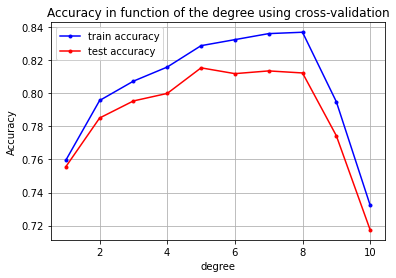

The degree obtaining the maximum test accuracy is :  8
 
And the associated maximum test accuracy is :  0.8185383980181667
 
While the train accuracy is :  0.8378062207541976


In [18]:
# parameters
degrees = 1+ np.arange(10)
k_fold = 4

#Plot
best_degree, acc_te_deg, acc_tr_deg = tune_best_one(y_, tX_, k_fold, least_squares, seed=seed, params=degrees, name='degree')
CV_param_plot(degrees, acc_tr_deg, acc_te_deg, name_param="degree")

# cross validation

deg_ls, acc_te_ls, acc_tr_ls = tune_best_deg(y_, tX_, k_fold, least_squares, degrees=degrees, seed=seed)
print('The degree obtaining the maximum test accuracy is : ', deg_ls)
print(' ')
print('And the associated maximum test accuracy is : ', acc_te_ls)
print(' ')
print('While the train accuracy is : ', acc_tr_ls)

### Method 4 : ridge_regression

#### "Parameters pre-tunage"

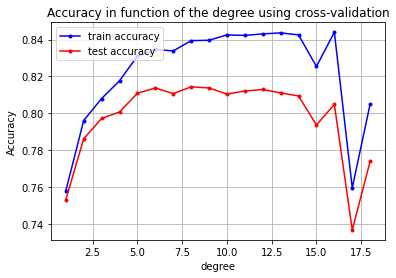

Accuracies for different degree :
[0.7533030553261768, 0.7863336085879439, 0.7972749793559042, 0.800784475639967, 0.8109000825763831, 0.8137902559867878, 0.8106936416184971, 0.814409578860446, 0.8137902559867878, 0.810487200660611, 0.8121387283236994, 0.8129644921552437, 0.8111065235342692, 0.8094549958711807, 0.7937654830718415, 0.8049132947976878, 0.7369942196531791, 0.7741535920726673]


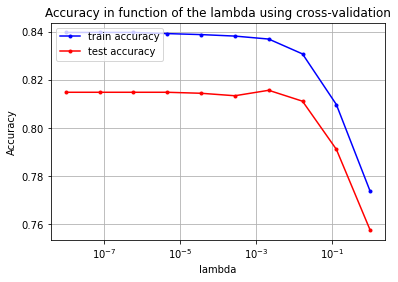

Accuracies for different lambda :
[0.814822460776218, 0.814822460776218, 0.814822460776218, 0.814822460776218, 0.8144095788604458, 0.8133773740710157, 0.8156482246077622, 0.8111065235342692, 0.7910817506193228, 0.7574318744838977]


In [19]:
# parameters
k_fold = 4

#Parameters to tune :
degrees = 1+ np.arange(18)
lambda_ = 1e-03 

best_degree, acc_te_deg, acc_tr_deg = tune_best_one(y_, tX_, k_fold, ridge_regression, seed=seed, params=degrees, lambda_=lambda_, name='degree')

CV_param_plot(degrees, acc_tr_deg, acc_te_deg, name_param="degree")

print("Accuracies for different degree :")
print(acc_te_deg)

#Parameters to tune :
degree = best_degree
lambdas = np.logspace(-8, 0, 10)

best_lam, acc_te_lam, acc_tr_lam = tune_best_one(y_, tX_, k_fold, ridge_regression, seed=seed, params=lambdas, degree=degree, name='lambda')

CV_param_plot(lambdas, acc_tr_lam, acc_te_lam, name_param="lambda")

print("Accuracies for different lambda :")
print(acc_te_lam)

Using this "pre-tunage", we can apply tune simultanesouly degree and gamma on a smaller grid search (to avoid very long computation).

In [20]:
degrees = [5, 6, 7, 8, 9, 10]
lambdas = np.logspace(-8, -3, 6)

#### Parameters tunage

In [21]:
# cross validation
deg_rr, lambda_rr, acc_te_rr, acc_tr_rr = tune_best_deg_lam(y_, tX_, k_fold, ridge_regression, degrees=degrees, lambdas=lambdas, seed=seed)

print('The degree obtaining the maximum test accuracy is : ', deg_rr)
print(' ')
print('With a lambda equal to : ', lambda_rr)
print(' ')
print('And the associated maximum test accuracy is : ', acc_te_rr)
print(' ')
print('While the train error is : ', acc_tr_rr)

The degree obtaining the maximum test accuracy is :  8
 
With a lambda equal to :  0.001
 
And the associated maximum test accuracy is :  0.8172997522708506
 
While the train error is :  0.837943848059455


### Method 5 : logistic_regression

#### "Parameters pre-tunage"

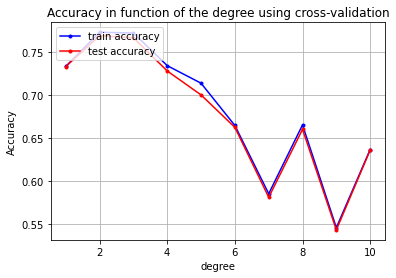

Accuracies for different degree :
[0.7330718414533443, 0.7689925681255161, 0.7665152766308836, 0.7279108175061932, 0.7000412881915772, 0.662262592898431, 0.5809248554913294, 0.6599917423616846, 0.5429397192402973, 0.6358381502890174]


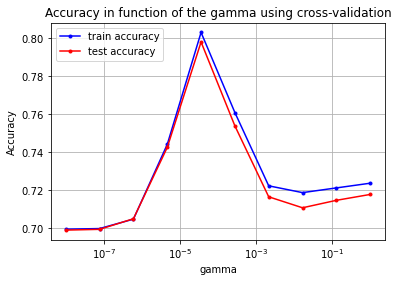

Accuracies for different gamma :
[0.699009083402147, 0.6994219653179191, 0.7049958711808424, 0.7425681255161024, 0.7981007431874484, 0.7539223781998349, 0.7165565648224608, 0.7107762180016515, 0.7146985962014863, 0.717795210569777]


In [22]:
# parameters
k_fold = 4
max_iters = 50

#Parameters to tune :
degrees = 1+ np.arange(10)
gamma = 1e-05

best_degree, acc_te_deg, acc_tr_deg = tune_best_one(y_, tX_, k_fold, logistic_regression, seed=seed, params=degrees, gamma=gamma, max_iters=max_iters, name='degree', log=True)

CV_param_plot(degrees, acc_tr_deg, acc_te_deg, name_param="degree")

print("Accuracies for different degree :")
print(acc_te_deg)

#Parameters to tune :
degree = best_degree
gammas = np.logspace(-8, 0, 10)

best_gam, acc_te_gam, acc_tr_gam = tune_best_one(y_, tX_, k_fold, logistic_regression, seed=seed, params=gammas, degree=degree, max_iters=max_iters, name='gamma', log=True)

CV_param_plot(gammas, acc_tr_gam, acc_te_gam, name_param="gamma")

print("Accuracies for different gamma :")
print(acc_te_gam)

Using this "pre-tunage", we can apply tune simultanesouly degree and gamma on a smaller grid search (to avoid very long computation).

In [23]:
degrees = [1, 2, 3]
gammas = np.logspace(-4, -3, 5)

#### Parameters tunage

In [24]:
# cross validation
deg_lr, gam_lr, acc_te_lr, acc_tr_lr = tune_best_deg_gam(y_, tX_, k_fold, logistic_regression, degrees=degrees, gammas=gammas, max_iters=max_iters, log=True, seed=seed)

print('The degree obtaining the maximum test accuracy is : ', deg_lr)
print(' ')
print('With a learning rate equal to : ', gam_lr)
print(' ')
print('And the associated maximum test accuracy is : ', acc_te_lr)
print(' ')
print('While the train accuracy is : ', acc_tr_lr)

The degree obtaining the maximum test accuracy is :  3
 
With a learning rate equal to :  0.0005623413251903491
 
And the associated maximum test accuracy is :  0.7524772914946325
 
While the train accuracy is :  0.7577759427470411


### Method 6 : reg_logistic_regression

#### "Parameters pre-tunage"

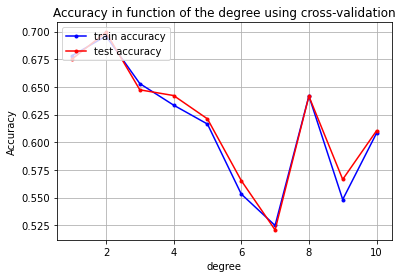

Accuracies for different degree :
[0.6752683732452518, 0.699421965317919, 0.6473988439306358, 0.6422378199834847, 0.6211808422791082, 0.5654417836498762, 0.5208505367464905, 0.6416184971098267, 0.5664739884393064, 0.6104459124690339]


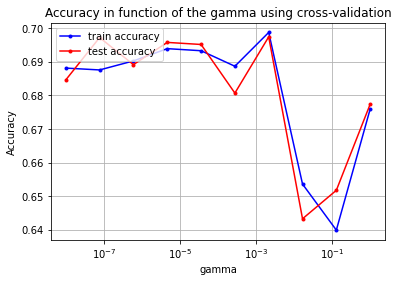

Accuracies for different gamma :
[0.6845582163501238, 0.6971511147811726, 0.6890999174236169, 0.6957060280759703, 0.6950867052023121, 0.680635838150289, 0.6973575557390588, 0.643270024772915, 0.6517341040462428, 0.6773327828241122]


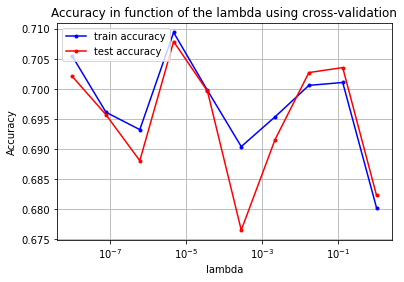

Accuracies for different lambda :
[0.7021056977704376, 0.6957060280759704, 0.6880677126341866, 0.7078860445912468, 0.699628406275805, 0.6765070189925682, 0.6915772089182494, 0.7027250206440958, 0.7035507844756401, 0.6822873658133773]


In [25]:
# parameters
k_fold = 4
max_iters=50


#Parameters to tune :
degrees=1+ np.arange(10)
gamma=0.0001
lambda_=1e-5

best_degree, acc_te_deg, acc_tr_deg = tune_best_one(y_, tX_, k_fold, reg_logistic_regression, seed=seed, params=degrees, gamma=gamma, lambda_=lambda_, max_iters=max_iters, name='degree', log=True)

CV_param_plot(degrees, acc_tr_deg, acc_te_deg, name_param="degree")

print("Accuracies for different degree :")
print(acc_te_deg)

#Parameters to tune :
degree=best_degree
gammas=np.logspace(-8, 0, 10)
lambda_=1e-5

best_gam, acc_te_gam, acc_tr_gam = tune_best_one(y_, tX_, k_fold, reg_logistic_regression, seed=seed, params=gammas, degree=degree, lambda_=lambda_, max_iters=max_iters, name='gamma', log=True)

CV_param_plot(gammas, acc_tr_gam, acc_te_gam, name_param="gamma")

print("Accuracies for different gamma :")
print(acc_te_gam)

#Parameters to tune :
degree=best_degree
gamma=best_gam
lambdas=np.logspace(-8, 0, 10)

best_lam, acc_te_lam, acc_tr_lam = tune_best_one(y_, tX_, k_fold, reg_logistic_regression, seed=seed, params=lambdas, degree=degree, gamma=gamma, max_iters=max_iters, name='lambda', log=True)

CV_param_plot(lambdas, acc_tr_lam, acc_te_lam, name_param="lambda")

print("Accuracies for different lambda :")
print(acc_te_lam)

Using this "pre-tunage", we can apply tune simultanesouly degree and gamma on a smaller grid search (to avoid very long computation).

In [26]:
degrees=[1, 2, 3]
gammas=np.logspace(-7, -1, 10)
lambdas=np.logspace(-7, -1, 10)

#### Parameters tunage

In [27]:
# cross validation
deg_lr_reg, gam_lr_reg, lambda_lr_reg, acc_te_lr_reg, acc_tr_lr_reg = tune_best_deg_lam_gam(y_, tX_, k_fold, reg_logistic_regression, degrees=degrees,
                                                                 lambdas=lambdas, gammas=gammas, log=True, seed=seed) 

print('The degree obtaining the maximum test accuracy is : ', deg_lr_reg)
print(' ')
print('With a gamma equal to : ', gam_lr_reg)
print(' ')
print('and a lambda equal to : ', lambda_lr_reg)
print(' ')
print('And the associated maximum test accuracy is : ', acc_te_lr_reg)
print(' ')
print('While the train accuracy is : ', acc_tr_lr_reg)

The degree obtaining the maximum test accuracy is :  1
 
With a gamma equal to :  4.641588833612772e-05
 
and a lambda equal to :  4.641588833612772e-05
 
And the associated maximum test accuracy is :  0.7167630057803468
 
While the train accuracy is :  0.7058216350123865


## Compare methods

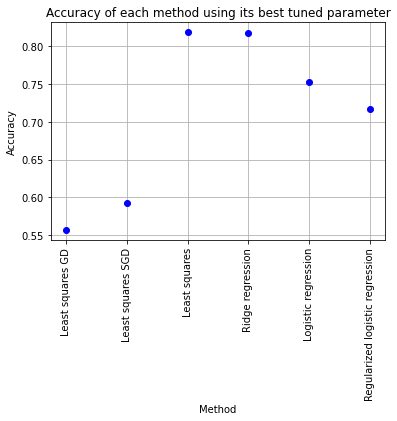

In [36]:
accuracies = [acc_te_ls_gd, acc_te_ls_sgd, acc_te_ls, acc_te_rr, acc_te_lr, acc_te_lr_reg]
methods = ['Least squares GD', 'Least squares SGD', 'Least squares', 'Ridge regression', 'Logistic regression', 'Regularized logistic regression']

compare(methods, accuracies)

## Generate predictions and save ouput in csv format for submission:

In [82]:
OUTPUT_PATH = 'data/second_submission.csv' # TODO: fill in desired name of output file for submission

In [83]:
tX_.shape

(242156, 27)

In [84]:
tX_deg10 = build_poly(tX_, 10)
tX_test_deg10 = build_poly(tX_test_,10)

In [85]:
w, _ = ridge_regression(y_, tX_deg10)

In [86]:
w.shape

(271,)

In [87]:
tX_test_.shape

(568238, 27)

In [88]:
y_pred = predict_labels(w, tX_test_deg10)

In [89]:
y_pred[y_pred==0] = -1
print(y_pred)

[-1. -1. -1. ... -1.  1. -1.]


In [90]:
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)